In [68]:
#mu and fwhm for barium

# mu_estimation=[64.66,82.17,106.98,141.28,57.7,76.3,103.05,139.2,68.79,93.9,128.39,64.21,89.93,124.35,51.24,71.47,101.29,50.08,70.11,100.26,143.3,205.65,293.56,663.49]
# rough_fwma=[15.168,18.467,18.92,22.41,9.51,10.15,11.65,14.82,7.66,10.57,13.94,7.56,10.09,13.78,6.478,8.58,12.18,7.36,09.02,2.31,17.87,24.92,38.55,75.74]
# sigma_estimation=[i/2.355 faor i in rough_fwma]
# print(sigma_estimation)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import os
import re

In [70]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

In [71]:
mu_estimation=[41.3,120.58,197.73,377.41,518.74,605.67,749.34,821.19,962.12,987.01]
rough_fwhm=[1.92,1.92,1.92,1.92,1.92,1.92,1.92,1.92,1.92,1.92]
sigma_estimation=[i/2.355 for i in rough_fwhm]
cap=1e-12
cal_voltage=[8.1,22.3,36.0,67.4,92.1,106.7,133.15,144.6,169.92,173.54]
del_cal_voltage=[1.9e-3,1.9e-3,2.15e-3,404e-6,410e-6,420e-6,570e-6,8114e-7,440e-6,506e-6]

In [72]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [73]:
directory = "team_battery"

# Regex to capture the float X from filenames like cal_10_(X).mca
pattern = re.compile(r"cal_10_(\d+\.?\d*)\.mca")

# Temporary storage for (x_value, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        x_value = float(match.group(1))
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))

# Sort by x_value
temp_storage.sort(key=lambda item: item[0])

# Separate into two lists
file_labels = [item[0] for item in temp_storage]
all_data_lists = [item[1] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")

Loaded 10 files in ascending order of X.
File 1 (X=8.1): 1024 points
File 2 (X=22.3): 1024 points
File 3 (X=36.0): 1024 points
File 4 (X=67.4): 1024 points
File 5 (X=92.1): 1024 points
File 6 (X=106.7): 1024 points
File 7 (X=133.15): 1024 points
File 8 (X=144.6): 1024 points
File 9 (X=169.92): 1024 points
File 10 (X=173.54): 1024 points


In [74]:
def fit_range(cal_list):
    range_list=[]
    for i in range(0,len(cal_list)):
        indices = np.where(np.array(cal_list[i]) > 13)[0].tolist()
        range_var=[min(indices)-10,max(indices)+10]
        range_list.append(range_var)
    return range_list

In [75]:
x=np.arange(0,len(all_data_lists[1]),1)
trial_range_list=fit_range(all_data_lists)
print(trial_range_list)
# print(all_data_lists[8])

[[30, 53], [109, 132], [186, 209], [366, 389], [507, 530], [594, 617], [738, 761], [810, 833], [951, 974], [975, 999]]


In [76]:
def gauss_fit(x,data,mu_est,sigma_est,range,file_labels):
    peak=np.max(data)
    #plottting the gaussian and fitting the data
    p0 = [peak,mu_est, sigma_est]
    mu, cov = sci.curve_fit(gaussian, x[range[0]:range[1]], data[range[0]:range[1]], p0=p0)
    fitted_curve = gaussian(x,*mu)
    plt.plot(x,data,label=f'{file_labels} V')
    plt.plot(x,fitted_curve,label='gaussian fit curve')
    # plt.xlim(range[0],range[1])
    plt.xlabel('Channel number')
    plt.ylabel('Counts')
    # plt.legend()
    return mu

[41.306624187005085, 120.5784014274675, 197.72542295811206, 377.40553227324654, 518.7425021458496, 605.6678402318882, 749.3471620701428, 821.1975468963205, 962.1222085293543, 987.015212427783] [0.6017527779466931, 0.6519988510343228, 0.6634044202165876, 0.6584669409038759, 0.6823209891051858, 0.6700135480999293, 0.6594253866283194, 0.6865432128135115, 0.6856006568772599, 0.6828914438306597]


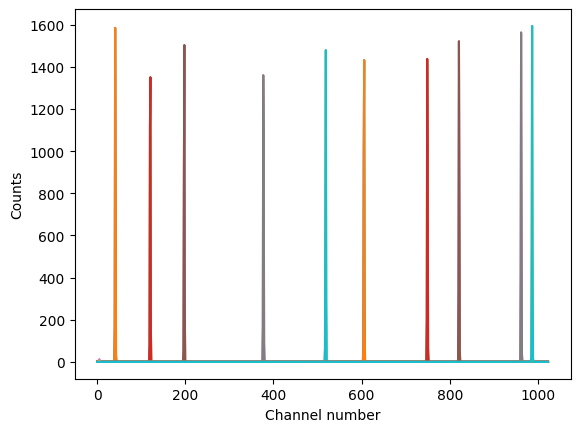

In [77]:
mu_list=[]
std_list=[]
for i in range(0,len(all_data_lists)):
    temp_fit=gauss_fit(x,all_data_lists[i],mu_estimation[i],sigma_estimation[i],trial_range_list[i],file_labels[i])
    mu_list.append(float(temp_fit[1]))
    std_list.append(float(temp_fit[2]))
print(mu_list,std_list)

 
1.751e-13 x + 1.164e-12
[41.306624187005085, 120.5784014274675, 197.72542295811206, 377.40553227324654, 518.7425021458496, 605.6678402318882, 749.3471620701428, 821.1975468963205, 962.1222085293543, 987.015212427783]
[0.6017527779466931, 0.6519988510343228, 0.6634044202165876, 0.6584669409038759, 0.6823209891051858, 0.6700135480999293, 0.6594253866283194, 0.6865432128135115, 0.6856006568772599, 0.6828914438306597]


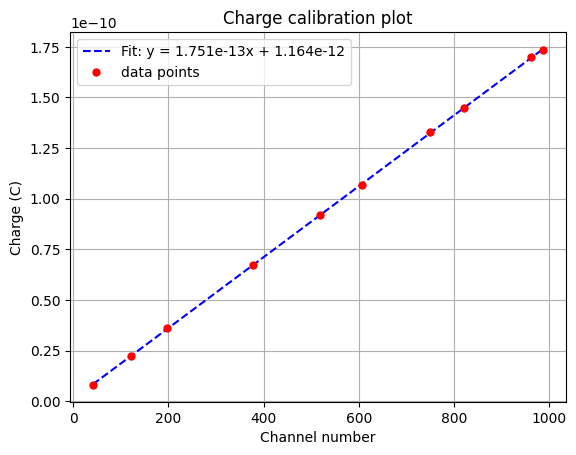

In [78]:

# x_mu=np.linspace(0,1024,10)
charge=[cal_voltage[j]*cap for j in range(0,len(cal_voltage))]
del_charge=[del_cal_voltage[i]*cap for i in range(0,len(del_cal_voltage))]
fit_1D=np.polyfit(mu_list,charge,deg=1)
fit_val=np.poly1d(fit_1D)
print(fit_val)
plt.plot(mu_list,fit_val(mu_list),'b--',label=f"Fit: y = 1.751e-13x + 1.164e-12")
plt.errorbar(mu_list,charge,yerr=del_charge,xerr=std_list,linestyle='none')
plt.plot(mu_list,charge,'r.',label='data points',ms=10)
plt.xlabel('Channel number')
plt.ylabel('Charge (C)')
plt.title('Charge calibration plot')
plt.legend()
plt.grid(True)
print(mu_list)
print(std_list)

In [ ]:
channel_no=np.arange(1,1025)
# print(channel_no)
def charge_cali(channels):
    charge_list= (1.751e-13*channels) + 1.164e-12
    return charge_list

charge_cali_list=charge_cali(channel_no)


[1.339100e-12 1.514200e-12 1.689300e-12 ... 1.801162e-10 1.802913e-10
 1.804664e-10]
